In [1]:
import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import vision
from google.cloud.vision import types

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import gensim
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from string import punctuation
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Thumbnail Labels - Cloud Vision API 

In [7]:
# Instantiates a client
client = vision.ImageAnnotatorClient.from_service_account_json('My-First-Project-020166277d8e.json') 

In [2]:
videos = pd.read_excel('Travelvideos_scraped.xlsx')
videos.head()

,Unnamed: 0,youID,title,thumbnail,Url,#Views,#Likes,#Dislikes
0,0,T144Ht7miiw,Storms hit during one of the busiest travel we...,https://i.ytimg.com/vi/T144Ht7miiw/default.jpg,https://www.youtube.com/watch?v=T144Ht7miiw,"17,087 views",432.0,62.0
1,1,68GaOZ_wPrc,Winter forecast ahead of holiday travel rush l...,https://i.ytimg.com/vi/68GaOZ_wPrc/default.jpg,https://www.youtube.com/watch?v=68GaOZ_wPrc,"132,721 views",636.0,223.0
2,2,M49Klw46_w8,How will the East Coast storms affect holiday ...,https://i.ytimg.com/vi/M49Klw46_w8/default.jpg,https://www.youtube.com/watch?v=M49Klw46_w8,"43,177 views",165.0,45.0
3,3,vcbWKnPHflQ,Dangerous Weather Could Disrupt Thanksgiving T...,https://i.ytimg.com/vi/vcbWKnPHflQ/default.jpg,https://www.youtube.com/watch?v=vcbWKnPHflQ,"26,848 views",106.0,16.0
4,4,EWEWUEqDvjc,Travel Girl | Episode 26 | Trincomalee - (2019...,https://i.ytimg.com/vi/EWEWUEqDvjc/default.jpg,https://www.youtube.com/watch?v=EWEWUEqDvjc,"1,398 views",52.0,5.0


In [3]:
thumbnails = videos['thumbnail']

In [10]:
#Loop to iterate through all the URLs of the thumbnails we scraped.
#Using the script we are making requests to the Google Vision API 
#to request information from an image, such as label detection.

count = 0
for url in thumbnails:
    labelstring = ['']
    image = types.Image()
    
    #Our Image URL
    image.source.image_uri = url

    #Making the request
    response = client.label_detection(image=image)
    
    #Getting all the labels
    labels = response.label_annotations

    for label in labels:
        labelstring.append(label.description)

    #Saving the labels in our dataframe 
    videos.loc[count,'labels'] = ', '.join(labelstring)
    count += 1

In [12]:
#Dropping the rows without labels. 
dropindex = videos[videos['labels'] == ""].index
videos.drop(index = dropindex, inplace=True)

In [13]:
#Saving the DataFrame into a file.
videos.to_csv('YouTube_labels.csv')

In [4]:
#Reading the file for double-checking
videolabels = pd.read_csv(r'YouTube_labels.csv')
videolabels.head()

,Unnamed: 0,Unnamed: 0.1,youID,title,thumbnail,Url,#Views,#Likes,#Dislikes,labels
0,0,0,T144Ht7miiw,Storms hit during one of the busiest travel we...,https://i.ytimg.com/vi/T144Ht7miiw/default.jpg,https://www.youtube.com/watch?v=T144Ht7miiw,"17,087 views",432.0,62.0,", Text, Mode of transport, Atmospheric phenome..."
1,1,1,68GaOZ_wPrc,Winter forecast ahead of holiday travel rush l...,https://i.ytimg.com/vi/68GaOZ_wPrc/default.jpg,https://www.youtube.com/watch?v=68GaOZ_wPrc,"132,721 views",636.0,223.0,", News, Display device, Display advertising, T..."
2,2,2,M49Klw46_w8,How will the East Coast storms affect holiday ...,https://i.ytimg.com/vi/M49Klw46_w8/default.jpg,https://www.youtube.com/watch?v=M49Klw46_w8,"43,177 views",165.0,45.0,", Text, Mode of transport, Font, Sky, Organism..."
3,3,3,vcbWKnPHflQ,Dangerous Weather Could Disrupt Thanksgiving T...,https://i.ytimg.com/vi/vcbWKnPHflQ/default.jpg,https://www.youtube.com/watch?v=vcbWKnPHflQ,"26,848 views",106.0,16.0,", Text, Atmospheric phenomenon, Mode of transp..."
4,4,4,EWEWUEqDvjc,Travel Girl | Episode 26 | Trincomalee - (2019...,https://i.ytimg.com/vi/EWEWUEqDvjc/default.jpg,https://www.youtube.com/watch?v=EWEWUEqDvjc,"1,398 views",52.0,5.0,", Hindu temple, Temple, Place of worship, Tour..."


# Clean Views Column

In [5]:
videolabels2 = videolabels.copy()

In [6]:
# remove words from the #Views column
videolabels2['#Views'] = videolabels2['#Views'].str.replace('views','')
videolabels2['#Views'] = videolabels2['#Views'].str.replace('view','')
videolabels2['#Views'] = videolabels2['#Views'].str.replace('No','0')

# remove commas and convert column to float
videolabels2['#Views'] = videolabels2['#Views'].str.replace(',','').astype(float)

videolabels2 = videolabels2.dropna()

videolabels2['#Views']

0          17087.0
1         132721.0
2          43177.0
3          26848.0
4           1398.0
5         274445.0
6        3220707.0
7        1283906.0
8         809111.0
9         147839.0
10           427.0
11         31571.0
12       1826169.0
13         38690.0
14        721932.0
16       1416327.0
17        630895.0
18       3943700.0
19       1759484.0
20        344289.0
21       3486501.0
22         61356.0
23          6555.0
24        678706.0
25        320307.0
26        652255.0
27        275854.0
28        179084.0
29           320.0
30       7862974.0
           ...    
2720       20203.0
2721          31.0
2722          24.0
2723           0.0
2724          15.0
2725          19.0
2727           1.0
2728          24.0
2729           0.0
2730           1.0
2732           3.0
2733          37.0
2734          64.0
2735          66.0
2736         187.0
2737      761903.0
2738       73354.0
2739      378011.0
2740        5153.0
2742      568885.0
2743      132576.0
2744        

In [7]:
videolabels2.drop(columns = ['Unnamed: 0','Unnamed: 0.1'], inplace=True)

In [8]:
# remove outliers - music videos

dropindex = [1630, 1631, 1837, 1988]
videolabels2.drop(index = dropindex, inplace=True)

In [9]:
videolabels2.shape

(2584, 8)

In [10]:
# Normalize number of views

maxViews = videolabels2['#Views'].max()
videolabels2['#Views'] = videolabels2['#Views']/maxViews

#Here are the top 3 most viewed videos
videolabels2[videolabels2['#Views']>0.55]

,youID,title,thumbnail,Url,#Views,#Likes,#Dislikes,labels
581,r3uL7kY2oYQ,Pencilmate Flies to His Vacation Destination!,https://i.ytimg.com/vi/r3uL7kY2oYQ/default.jpg,https://www.youtube.com/watch?v=r3uL7kY2oYQ,0.580136,296062.0,68487.0,", Cartoon, Illustration, Art"
982,m80SpeAncyI,Amelia and Avelina beach vacation adventure,https://i.ytimg.com/vi/m80SpeAncyI/default.jpg,https://www.youtube.com/watch?v=m80SpeAncyI,0.603818,180149.0,65632.0,", People, Facial expression, Font, Text, Fun, ..."
1595,JRSYMfC2PFU,Lion Shows Tourists Why You Must Stay Inside Y...,https://i.ytimg.com/vi/JRSYMfC2PFU/default.jpg,https://www.youtube.com/watch?v=JRSYMfC2PFU,1.000000,105795.0,44929.0,", Mammal, Vertebrate, Mode of transport, Dog, ..."


In [11]:
medianViews = videolabels2['#Views'].median()

# create engagement high or low classifier based on median score
videolabels2['engagement'] = np.where(videolabels2['#Views'] > medianViews, 1, 0)
videolabels2.head(10)

,youID,title,thumbnail,Url,#Views,#Likes,#Dislikes,labels,engagement
0,T144Ht7miiw,Storms hit during one of the busiest travel we...,https://i.ytimg.com/vi/T144Ht7miiw/default.jpg,https://www.youtube.com/watch?v=T144Ht7miiw,0.000149,432.0,62.0,", Text, Mode of transport, Atmospheric phenome...",0
1,68GaOZ_wPrc,Winter forecast ahead of holiday travel rush l...,https://i.ytimg.com/vi/68GaOZ_wPrc/default.jpg,https://www.youtube.com/watch?v=68GaOZ_wPrc,0.001159,636.0,223.0,", News, Display device, Display advertising, T...",0
2,M49Klw46_w8,How will the East Coast storms affect holiday ...,https://i.ytimg.com/vi/M49Klw46_w8/default.jpg,https://www.youtube.com/watch?v=M49Klw46_w8,0.000377,165.0,45.0,", Text, Mode of transport, Font, Sky, Organism...",0
3,vcbWKnPHflQ,Dangerous Weather Could Disrupt Thanksgiving T...,https://i.ytimg.com/vi/vcbWKnPHflQ/default.jpg,https://www.youtube.com/watch?v=vcbWKnPHflQ,0.000234,106.0,16.0,", Text, Atmospheric phenomenon, Mode of transp...",0
4,EWEWUEqDvjc,Travel Girl | Episode 26 | Trincomalee - (2019...,https://i.ytimg.com/vi/EWEWUEqDvjc/default.jpg,https://www.youtube.com/watch?v=EWEWUEqDvjc,0.000012,52.0,5.0,", Hindu temple, Temple, Place of worship, Tour...",0
5,_EkO2ofPOXg,Jordan Vacation Travel Guide | Expedia (4K),https://i.ytimg.com/vi/_EkO2ofPOXg/default.jpg,https://www.youtube.com/watch?v=_EkO2ofPOXg,0.002396,2047.0,96.0,", Text, Font, Banner, Signage, Vehicle registr...",1
6,nPOO1Coe2DI,Dubai Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/nPOO1Coe2DI/default.jpg,https://www.youtube.com/watch?v=nPOO1Coe2DI,0.028123,17241.0,1077.0,", Text, Font, Advertising, Signage, Banner, Di...",1
7,LcKnx7I97yk,Dublin Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/LcKnx7I97yk/default.jpg,https://www.youtube.com/watch?v=LcKnx7I97yk,0.011211,7445.0,292.0,", Banner, Font, Text, Advertising, Mode of tra...",1
8,0Mv48ZM7gu4,Brisbane Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/0Mv48ZM7gu4/default.jpg,https://www.youtube.com/watch?v=0Mv48ZM7gu4,0.007065,3451.0,135.0,", Land lot, Grass, Font, Banner, Sport venue, ...",1
9,llq8Rjm6wKc,Stockholm Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/llq8Rjm6wKc/default.jpg,https://www.youtube.com/watch?v=llq8Rjm6wKc,0.001291,1807.0,47.0,", Text, Font, Lighting, Vehicle registration p...",1


# Linear Regression

In [12]:
#Saving X and Y

x = videolabels2.loc[:,['labels','title']]
y = videolabels2.loc[:,'engagement']

# Logistic Regression

### Thumbnail Image as X

In [126]:
#Saving X and Y

x = videolabels2.loc[:,'labels']
y = videolabels2.loc[:,'engagement']

In [129]:
#Splitting into Train and Test

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [130]:
#Transforming the training and testing independent variables using a TFIDF Vectorizer.
#TF-IDF BASED FEATURE REPRESENTATION

tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
tfidf_vectorizer.fit_transform(X_train.values)
        
train_labels=tfidf_vectorizer.transform(X_train.values)
test_labels=tfidf_vectorizer.transform(X_test.values)

In [131]:
#Building the Logistic Regression model and training it.

scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
model=scikit_log_reg.fit(train_labels,y_train)

[LibLinear]

In [132]:
#Predicting on test data using the model.

y_pred = model.predict(test_labels)
print("Accuracy Score",accuracy_score(y_pred,y_test))

Accuracy Score 0.6114551083591331


### Video Title as X

In [133]:
#Saving X and Y

x = videolabels2.loc[:,'title']
y = videolabels2.loc[:,'engagement']

In [134]:
#Splitting into Train and Test

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [135]:
#Transforming the training and testing independent variables using a TFIDF Vectorizer.
#TF-IDF BASED FEATURE REPRESENTATION

tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
tfidf_vectorizer.fit_transform(X_train.values)
        
train_title=tfidf_vectorizer.transform(X_train.values)
test_title=tfidf_vectorizer.transform(X_test.values)

In [136]:
#Building the Logistic Regression model and training it.

scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
model=scikit_log_reg.fit(train_title,y_train)

[LibLinear]

In [137]:
#Predicting on test data using the model.

y_pred = model.predict(test_title)
print("Accuracy Score",accuracy_score(y_pred,y_test))

Accuracy Score 0.7244582043343654


### Both Title and Image as X

In [138]:
videolabels2['combined'] = videolabels2['labels'] + videolabels2['title']
x = videolabels2.loc[:,'combined']
y = videolabels2.loc[:,'engagement']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [140]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
tfidf_vectorizer.fit_transform(X_train.values)     

train_combined=tfidf_vectorizer.transform(X_train.values)
test_combined=tfidf_vectorizer.transform(X_test.values)

In [142]:
X_train_final = np.c_[train_combined,train_labels]
X_test_final = np.hstack((test_combined,test_labels))

In [145]:
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
model=scikit_log_reg.fit(train_combined,y_train)


[LibLinear]

In [146]:
y_pred = model.predict(test_combined)
print("Accuracy Score",accuracy_score(y_pred,y_test))

Accuracy Score 0.7352941176470589


# Topic Modeling

In [182]:
dataforlda = videolabels2.copy()
dataforlda.head()

,youID,title,thumbnail,Url,#Views,#Likes,#Dislikes,labels,engagement,combined
0,T144Ht7miiw,Storms hit during one of the busiest travel we...,https://i.ytimg.com/vi/T144Ht7miiw/default.jpg,https://www.youtube.com/watch?v=T144Ht7miiw,0.000149,432.0,62.0,", Text, Mode of transport, Atmospheric phenome...",0,", Text, Mode of transport, Atmospheric phenome..."
1,68GaOZ_wPrc,Winter forecast ahead of holiday travel rush l...,https://i.ytimg.com/vi/68GaOZ_wPrc/default.jpg,https://www.youtube.com/watch?v=68GaOZ_wPrc,0.001159,636.0,223.0,", News, Display device, Display advertising, T...",0,", News, Display device, Display advertising, T..."
2,M49Klw46_w8,How will the East Coast storms affect holiday ...,https://i.ytimg.com/vi/M49Klw46_w8/default.jpg,https://www.youtube.com/watch?v=M49Klw46_w8,0.000377,165.0,45.0,", Text, Mode of transport, Font, Sky, Organism...",0,", Text, Mode of transport, Font, Sky, Organism..."
3,vcbWKnPHflQ,Dangerous Weather Could Disrupt Thanksgiving T...,https://i.ytimg.com/vi/vcbWKnPHflQ/default.jpg,https://www.youtube.com/watch?v=vcbWKnPHflQ,0.000234,106.0,16.0,", Text, Atmospheric phenomenon, Mode of transp...",0,", Text, Atmospheric phenomenon, Mode of transp..."
4,EWEWUEqDvjc,Travel Girl | Episode 26 | Trincomalee - (2019...,https://i.ytimg.com/vi/EWEWUEqDvjc/default.jpg,https://www.youtube.com/watch?v=EWEWUEqDvjc,0.000012,52.0,5.0,", Hindu temple, Temple, Place of worship, Tour...",0,", Hindu temple, Temple, Place of worship, Tour..."


In [191]:
#For each label which was a String, replace it with an array of labels. 

i=0
dataforlda.loc[:,'cleanlabels'] = "0"
for comment in dataforlda['labels']:
    temparray = comment.split(", ")
    youtube.at[i,'cleanlabels'] = temparray[1:]
    #print(temparray[1:])
    #dataforlda.at[i,'cleanlabels'] = temparray[1:]
    i+=1
#dataforlda.head(10)

In [221]:
youtube = pd.DataFrame(columns=['cleanlabels','cleantitles'])

In [222]:
youtube.head()

,cleanlabels,cleantitles


In [194]:
    
master_list = []
i=0

for comment in dataforlda['labels']:
        temparray = comment.split(", ")
        words = [word.lower() for word in temparray]

        #Remove single-character tokens (mostly punctuation)
        words = [word for word in words if len(word) > 1]
        master_list.extend(words)
    

wordfreq = FreqDist(master_list)
wordfreq

FreqDist({'font': 1185, 'photography': 744, 'text': 676, 'sky': 466, 'fun': 415, 'mode of transport': 348, 'tree': 341, 'banner': 301, 'photo caption': 298, 'tourism': 292, ...})

In [195]:
#Converting the Cleaned 'labels' column into a dictionary.
dictionary = gensim.corpora.Dictionary(youtube['cleanlabels'])

#Printing the dictionary
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 Atmospheric phenomenon
1 City
2 Font
3 Geological phenomenon
4 Mode of transport
5 Photography
6 Sky
7 Text
8 Water
9 Advertising
10 Display advertising


In [196]:
#Bag of words model uses the above dictionary to assign the key to the labels

bow_corpus = [dictionary.doc2bow(doc) for doc in youtube['cleanlabels']]
bow_corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1)],
 [(2, 1), (4, 1), (6, 1), (7, 1), (17, 1), (19, 1), (20, 1), (21, 1), (22, 1)],
 [(0, 1), (2, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)],
 [(2, 1),
  (7, 1),
  (9, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1)],
 [(2, 1),
  (6, 1),
  (7, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (30, 1),
  (34, 1),
  (36, 1),
  (37, 1)],
 [(2, 1),
  (4, 1),
  (7, 1),
  (9, 1),
  (30, 1),
  (34, 1),
  (35, 1),
  (38, 1),
  (39, 1),
  (40, 1)],
 [(2, 1),
  (30, 1),
  (34, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1)],
 [(2, 1),
  (7, 1),
  (9, 1),
  (30, 1),
  (34, 1),
  (35, 1),
  (38, 1),
  (48, 1),
  (49, 1),
  (50, 1)],
 [(4, 1),
  (35, 1),
  (48, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  

In [197]:
#Creating a LDA model with topic = 5.
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [198]:
#These are the topic and the labels and weights associated with each of them

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"
Topic: 1 
Words: 0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"
Topic: 2 
Words: 0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"
Topic: 3 
Words: 0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"
Topic: 4 
Words: 0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism

In [199]:
#For each image we are assigning a Topic with the maximum weight amongst all the topics.
#Also we are savig the weights for each of the topics in separate columns.

i=0
for row in bow_corpus:
    ind =0
    sco =0 
    for index, score in sorted(lda_model[row], key=lambda tup: -1*tup[1]):
        if(ind ==0 and sco == 0):
            dataforlda.at[i,'Topic Final'] = index
            print("\nScore: {}\t \nTopic: {}\n{}".format(score,index,lda_model.print_topic(index, 10)))
        if(index == 0):
            dataforlda.at[i,'Topic 0']= score
        elif(index == 1):
            dataforlda.at[i,'Topic 1']= score
        elif(index == 2):
            dataforlda.at[i,'Topic 2']= score
        elif(index == 3):
            dataforlda.at[i,'Topic 3']= score
        else:
            dataforlda.at[i,'Topic 4']= score 
        ind+=1
        sco+=1 
    i+=1


Score: 0.5804293751716614	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.9267244935035706	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.7224816083908081	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.6651864647865295	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.8968455195426941	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"


Score: 0.48103657364845276	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.7959239482879639	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.5941428542137146	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.9094159603118896	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.9188340902328491	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024


Score: 0.5778449177742004	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.9264662265777588	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.3872303366661072	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.6738625764846802	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.47168856859207153	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" +


Score: 0.7955741286277771	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.9270893335342407	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.7454439401626587	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.9262869954109192	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.8852478265762329	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tour


Score: 0.6151112914085388	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.7303701043128967	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.8371762037277222	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.910393476486206	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.795451283454895	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 


Score: 0.7288385629653931	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.9195493459701538	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.8618307709693909	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.9095351696014404	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.9193452596664429	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.


Score: 0.5931358337402344	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.5946353673934937	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.9251431822776794	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.8361390829086304	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.5931581854820251	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0


Score: 0.8981940746307373	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.8659840822219849	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.5831376314163208	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.630370557308197	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.9089571833610535	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"S


Score: 0.9268844723701477	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.7985273003578186	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.8371108174324036	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.9268041253089905	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.9096351265907288	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*


Score: 0.6752523183822632	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.9259448051452637	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.9194738864898682	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.76694256067276	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.6869893074035645	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"P


Score: 0.9084794521331787	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.5930718779563904	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.9259235858917236	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.6860677599906921	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.5182088017463684	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.


Score: 0.7980011701583862	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.8839431405067444	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.8977837562561035	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.7950569987297058	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.9184918403625488	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropoli

0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.924709677696228	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.8636029362678528	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.9257799386978149	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.589846670627594	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" 


Score: 0.727780818939209	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.9263043403625488	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.654793381690979	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.7310802340507507	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.7259863615036011	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption


Score: 0.9264922142028809	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.8851662278175354	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.8322215676307678	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.9245217442512512	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.9257571697235107	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"


Score: 0.7773715257644653	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.8840826153755188	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.9254912734031677	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.836711585521698	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.7324431538581848	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*


Score: 0.8648099899291992	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.9260819554328918	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.723004162311554	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.7254627346992493	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.5138037800788879	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.0


Score: 0.7977973222732544	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.7621027231216431	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.6989232301712036	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.9264857769012451	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.9252333045005798	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.03

0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.7251060009002686	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.7245546579360962	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.9263408184051514	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.8381977677345276	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Game


Score: 0.927044689655304	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.7352277040481567	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.729191243648529	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.8834326267242432	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.926729142665863	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"


Score: 0.7948849201202393	 
Topic: 3
0.092*"Font" + 0.053*"Text" + 0.032*"Photography" + 0.024*"Banner" + 0.021*"Photo caption" + 0.018*"Sky" + 0.018*"Fun" + 0.017*"Games" + 0.017*"Head" + 0.017*"Face"

Score: 0.7473227381706238	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.9261893630027771	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.521083652973175	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.8637008666992188	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.02


Score: 0.9265429973602295	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.8986017107963562	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.8388577103614807	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.6163206100463867	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.7080609798431396	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mod


Score: 0.9082717895507812	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.9190101027488708	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.5796241164207458	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.9259548187255859	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.4727044999599457	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"


Score: 0.837621808052063	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.9262716770172119	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.5615317821502686	 
Topic: 4
0.041*"Photography" + 0.033*"City" + 0.029*"Sky" + 0.028*"Landmark" + 0.027*"Metropolitan area" + 0.024*"Human settlement" + 0.022*"Tree" + 0.021*"Mode of transport" + 0.019*"Event" + 0.018*"Tourism"

Score: 0.9088302850723267	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.8371669054031372	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.


Score: 0.7211013436317444	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030*"Water" + 0.025*"Tree" + 0.024*"Photography" + 0.021*"Landscape" + 0.018*"Sea" + 0.016*"Water resources"

Score: 0.7301679849624634	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.730165958404541	 
Topic: 0
0.069*"Font" + 0.034*"Text" + 0.034*"Photography" + 0.025*"Technology" + 0.024*"Photo caption" + 0.023*"Art" + 0.021*"Tree" + 0.021*"Advertising" + 0.020*"Organism" + 0.020*"Mode of transport"

Score: 0.5201799869537354	 
Topic: 2
0.050*"Photography" + 0.041*"Fun" + 0.039*"Vehicle" + 0.033*"Mode of transport" + 0.032*"Font" + 0.028*"Tourism" + 0.020*"Leisure" + 0.019*"Vacation" + 0.018*"Water" + 0.016*"Recreation"

Score: 0.9270400404930115	 
Topic: 1
0.051*"Sky" + 0.050*"Font" + 0.045*"Nature" + 0.038*"Text" + 0.030

In [202]:
lowthreshold = dataforlda.describe().loc['25%','#Views']
highthreshold = dataforlda.describe().loc['75%','#Views']

In [205]:
firstquartile = dataforlda[dataforlda['#Views']<=lowthreshold].copy()
firstquartile

,youID,title,thumbnail,Url,#Views,#Likes,#Dislikes,labels,engagement,combined,cleanlabels,Topic Final,Topic 1,Topic 4,Topic 2,Topic 3,Topic 0
4,EWEWUEqDvjc,Travel Girl | Episode 26 | Trincomalee - (2019...,https://i.ytimg.com/vi/EWEWUEqDvjc/default.jpg,https://www.youtube.com/watch?v=EWEWUEqDvjc,1.220720e-05,52.0,5.0,", Hindu temple, Temple, Place of worship, Tour...",0.0,", Hindu temple, Temple, Place of worship, Tour...",0,0.0,0.025234,0.026016,0.025947,0.025958,0.896846
10,Z43fVnDAZYQ,Busy holiday travel season on the roads and skies,https://i.ytimg.com/vi/Z43fVnDAZYQ/default.jpg,https://www.youtube.com/watch?v=Z43fVnDAZYQ,3.728523e-06,0.0,1.0,", Motor vehicle, Mode of transport, Vehicle, V...",0.0,", Motor vehicle, Mode of transport, Vehicle, V...",0,2.0,0.018302,0.339406,0.605543,0.018349,0.018400
23,kPWT6rz2z2M,PAKISTAN- 10 THINGS TO KNOW BEFORE TRAVELLING ...,https://i.ytimg.com/vi/kPWT6rz2z2M/default.jpg,https://www.youtube.com/watch?v=kPWT6rz2z2M,5.723764e-05,930.0,16.0,", Text, Font, Vehicle registration plate, Mode...",0.0,", Text, Font, Vehicle registration plate, Mode...",0,4.0,0.018295,0.640286,0.018378,0.304768,0.018273
29,ejG2hq_LM9U,"Sambil Menangis, Juru Bicara Korban Penipuan F...",https://i.ytimg.com/vi/ejG2hq_LM9U/default.jpg,https://www.youtube.com/watch?v=ejG2hq_LM9U,2.794210e-06,31.0,2.0,", People, Child, Smile, Photography, Vehicle",0.0,", People, Child, Smile, Photography, VehicleSa...",0,0.0,0.025289,0.025310,0.025901,0.025686,0.897814
32,wuBP8LbLNSQ,Holiday travel rush begins in Houston,https://i.ytimg.com/vi/wuBP8LbLNSQ/default.jpg,https://www.youtube.com/watch?v=wuBP8LbLNSQ,2.139317e-06,8.0,1.0,", Crowd, Event, Fun, Performance",0.0,", Crowd, Event, Fun, PerformanceHoliday travel...",0,3.0,0.018700,0.018417,0.018455,0.925837,0.018591
54,z3c6c25eaPo,The Science and Fiction of Time Travel - Part 2,https://i.ytimg.com/vi/z3c6c25eaPo/default.jpg,https://www.youtube.com/watch?v=z3c6c25eaPo,2.060730e-05,110.0,8.0,", Text, Font",0.0,", Text, FontThe Science and Fiction of Time Tr...",0,1.0,0.769910,0.018487,0.018683,0.018698,0.174222
81,n8qvFP07L8o,3-Day Travel Guide For Things To Do and Foods ...,https://i.ytimg.com/vi/n8qvFP07L8o/default.jpg,https://www.youtube.com/watch?v=n8qvFP07L8o,3.311138e-05,185.0,4.0,", Food, Cuisine, Dish, Ingredient, Ramen, Nood...",0.0,", Food, Cuisine, Dish, Ingredient, Ramen, Nood...",0,3.0,0.102073,0.100539,0.101250,0.593036,0.103102
83,87PeYmTXtOY,HUSBAND COOKING VLOG MALAYALAM | FT. HANNA DAN...,https://i.ytimg.com/vi/87PeYmTXtOY/default.jpg,https://www.youtube.com/watch?v=87PeYmTXtOY,4.549323e-05,236.0,4.0,", Font",0.0,", FontHUSBAND COOKING VLOG MALAYALAM | FT. HAN...",0,0.0,0.051171,0.050055,0.050234,0.051567,0.796973
89,_XM9L2VeMYI,Family Travel to the Nation&#39;s Capital,https://i.ytimg.com/vi/_XM9L2VeMYI/default.jpg,https://www.youtube.com/watch?v=_XM9L2VeMYI,5.396317e-06,52.0,2.0,", Transport, Product, Mode of transport, Techn...",0.0,", Transport, Product, Mode of transport, Techn...",0,1.0,0.760729,0.018376,0.184300,0.018280,0.018315
120,jE3Ne_YaiGY,Caravan to Quartzsite - A Travel Day with Friends,https://i.ytimg.com/vi/jE3Ne_YaiGY/default.jpg,https://www.youtube.com/watch?v=jE3Ne_YaiGY,4.425330e-05,776.0,11.0,", Mode of transport, Font, Photo caption",0.0,", Mode of transport, Font, Photo captionCarava...",0,3.0,0.020504,0.020129,0.020114,0.918834,0.020419


In [206]:
fourthquartile = dataforlda[dataforlda['#Views']>= highthreshold].copy()
fourthquartile

,youID,title,thumbnail,Url,#Views,#Likes,#Dislikes,labels,engagement,combined,cleanlabels,Topic Final,Topic 1,Topic 4,Topic 2,Topic 3,Topic 0
6,nPOO1Coe2DI,Dubai Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/nPOO1Coe2DI/default.jpg,https://www.youtube.com/watch?v=nPOO1Coe2DI,0.028123,17241.0,1077.0,", Text, Font, Advertising, Signage, Banner, Di...",1.0,", Text, Font, Advertising, Signage, Banner, Di...",0,3.0,0.018574,0.018296,0.018270,0.926234,0.018626
7,LcKnx7I97yk,Dublin Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/LcKnx7I97yk/default.jpg,https://www.youtube.com/watch?v=LcKnx7I97yk,0.011211,7445.0,292.0,", Banner, Font, Text, Advertising, Mode of tra...",1.0,", Banner, Font, Text, Advertising, Mode of tra...",0,0.0,0.018543,0.018526,0.018540,0.463031,0.481360
12,ieWNzZPfZzk,Rio de Janeiro Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/ieWNzZPfZzk/default.jpg,https://www.youtube.com/watch?v=ieWNzZPfZzk,0.015946,8305.0,482.0,", Text, Font, Advertising, Display device, Mod...",1.0,", Text, Font, Advertising, Display device, Mod...",0,3.0,0.018658,0.018431,0.018479,0.925618,0.018814
16,srP7RFVdjWc,Cape Town Vacation Travel Guide | Expedia (4K),https://i.ytimg.com/vi/srP7RFVdjWc/default.jpg,https://www.youtube.com/watch?v=srP7RFVdjWc,0.012367,7886.0,272.0,", Nature, Text, Banner, Font, Sky, Water, Adve...",1.0,", Nature, Text, Banner, Font, Sky, Water, Adve...",0,3.0,0.022540,0.022261,0.022344,0.910326,0.022530
18,Oo6iAxf4si0,San Francisco Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/Oo6iAxf4si0/default.jpg,https://www.youtube.com/watch?v=Oo6iAxf4si0,0.034436,16882.0,758.0,", Text, Landmark, Font, Sky, Mode of transport...",1.0,", Text, Landmark, Font, Sky, Mode of transport...",0,1.0,0.924893,0.018653,0.018994,0.018679,0.018780
19,nD_dFyfOXIo,Patagonia Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/nD_dFyfOXIo/default.jpg,https://www.youtube.com/watch?v=nD_dFyfOXIo,0.015364,8500.0,311.0,", Nature, Sky, Text, Font, Shore, Mode of tran...",1.0,", Nature, Sky, Text, Font, Shore, Mode of tran...",0,3.0,0.284914,0.018429,0.018369,0.659661,0.018627
21,45ETZ1xvHS0,London Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/45ETZ1xvHS0/default.jpg,https://www.youtube.com/watch?v=45ETZ1xvHS0,0.030444,15207.0,786.0,", Vehicle registration plate, Text, Signage, F...",1.0,", Vehicle registration plate, Text, Signage, F...",0,0.0,0.028973,0.028635,0.028632,0.028753,0.885007
30,sRyslbdtT90,31 INSANELY AFFORDABLE Budget Travel Destinati...,https://i.ytimg.com/vi/sRyslbdtT90/default.jpg,https://www.youtube.com/watch?v=sRyslbdtT90,0.068659,262482.0,6009.0,", Technology, Font, Games, Electronic device, ...",1.0,", Technology, Font, Games, Electronic device, ...",0,3.0,0.020583,0.020153,0.020146,0.918686,0.020432
31,7uY0Ab5HlZ0,Toronto Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/7uY0Ab5HlZ0/default.jpg,https://www.youtube.com/watch?v=7uY0Ab5HlZ0,0.015328,8087.0,304.0,", Text, Font, Banner, Display advertising, Adv...",1.0,", Text, Font, Banner, Display advertising, Adv...",0,4.0,0.040290,0.835872,0.041490,0.040901,0.041447
35,RLOsQViPLhw,Melbourne Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/RLOsQViPLhw/default.jpg,https://www.youtube.com/watch?v=RLOsQViPLhw,0.010953,4838.0,198.0,", Font, Landmark, Text, Advertising, Display a...",1.0,", Font, Landmark, Text, Advertising, Display a...",0,0.0,0.465380,0.018475,0.018522,0.018651,0.478972


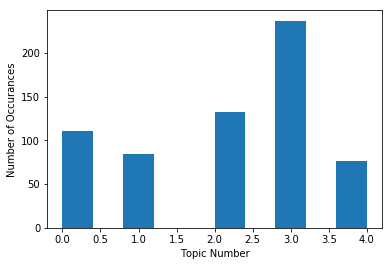

In [209]:
#Plotting the Topic vs. Frequency of Occurance in the 4th Quartile
#This is where the engagement score is the maximum. 

plt.ylabel("Number of Occurances")
plt.xlabel("Topic Number")
plt.hist(fourthquartile['Topic Final'])
plt.show()

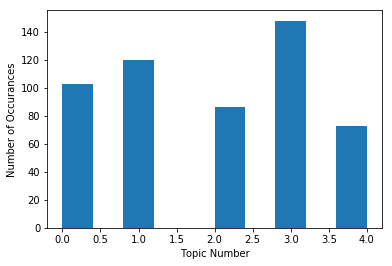

In [210]:
#Plotting the Topic vs. Frequency of Occurance in the 1st Quartile
#This is where the engagement score is the minimum. 

plt.ylabel("Number of Occurances")
plt.xlabel("Topic Number")
plt.hist(firstquartile['Topic Final'])
plt.show()

# TF-IDF

In [211]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5665608168749158),
 (1, 0.35054986356575607),
 (2, 0.10129106706435272),
 (3, 0.5262631097984292),
 (4, 0.26049086564542057),
 (5, 0.16176681284824304),
 (6, 0.22255417481268475),
 (7, 0.17422011477810928),
 (8, 0.30822701210419223)]


In [212]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=6, id2word=dictionary, passes=2, workers=4) #Thank you Susan.
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWord: {}\n'.format(idx, topic))

Topic: 0 
Word: 0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Topic: 1 
Word: 0.017*"Grass" + 0.016*"Tree" + 0.014*"Mode of transport" + 0.014*"Leisure" + 0.014*"Vehicle" + 0.013*"Recreation" + 0.012*"Photography" + 0.010*"Fun" + 0.009*"Extreme sport" + 0.009*"Nature"

Topic: 2 
Word: 0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Topic: 3 
Word: 0.016*"Face" + 0.016*"Nose" + 0.015*"Head" + 0.014*"Font" + 0.014*"Performance" + 0.013*"Event" + 0.013*"Music" + 0.013*"Cheek" + 0.012*"Forehead" + 0.012*"Chin"

Topic: 4 
Word: 0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Topic: 

In [213]:
i=0
for row in bow_corpus:
    ind =0
    sco =0 
    for index, score in sorted(lda_model_tfidf[row], key=lambda tup: -1*tup[1]):
        if(ind ==0 and sco == 0):
            dataforlda.at[i,'Topic Final'] = index
            print("\nScore: {}\t \nTopic: {}\n{}".format(score,index,lda_model_tfidf.print_topic(index, 10)))
        if(index == 0):
            dataforlda.at[i,'Topic 0']= score
        elif(index == 1):
            dataforlda.at[i,'Topic 1']= score
        elif(index == 2):
            dataforlda.at[i,'Topic 2']= score
        elif(index == 3):
            dataforlda.at[i,'Topic 3']= score
        elif(index == 4):
            dataforlda.at[i,'Topic 4']= score
        elif(index == 5):
            dataforlda.at[i,'Topic 5']= score
#         elif(index == 6):
#             dataforlda.at[i,'Topic 6']= score
#         elif(index == 7):
#             dataforlda.at[i,'Topic 7']= score
#         elif(index == 8):
#             dataforlda.at[i,'Topic 8']= score
#         elif(index == 9):
#             dataforlda.at[i,'Topic 9']= score 
        ind+=1
        sco+=1 
    i+=1


Score: 0.9156395196914673	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.9238325953483582	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.5149577260017395	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.5578487515449524	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.8952528238296509	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 


Score: 0.9072408080101013	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.5189517140388489	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.7909027338027954	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.579656183719635	 
Topic: 3
0.016*"Face" + 0.016*"Nose" + 0.015*"Head" + 0.014*"Font" + 0.014*"Performance" + 0.013*"Event" + 0.013*"Music" + 0.013*"Cheek" + 0.012*"Forehead" + 0.012*"Chin"

Score: 0.4668982923030853	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.01


Score: 0.472145676612854	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.894852340221405	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.6499417424201965	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.8795851469039917	 
Topic: 3
0.016*"Face" + 0.016*"Nose" + 0.015*"Head" + 0.014*"Font" + 0.014*"Performance" + 0.013*"Event" + 0.013*"Music" + 0.013*"Cheek" + 0.012*"Forehead" + 0.012*"Chin"

Score: 0.5819184184074402	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"To


Score: 0.5440039038658142	 
Topic: 1
0.017*"Grass" + 0.016*"Tree" + 0.014*"Mode of transport" + 0.014*"Leisure" + 0.014*"Vehicle" + 0.013*"Recreation" + 0.012*"Photography" + 0.010*"Fun" + 0.009*"Extreme sport" + 0.009*"Nature"

Score: 0.7208284139633179	 
Topic: 3
0.016*"Face" + 0.016*"Nose" + 0.015*"Head" + 0.014*"Font" + 0.014*"Performance" + 0.013*"Event" + 0.013*"Music" + 0.013*"Cheek" + 0.012*"Forehead" + 0.012*"Chin"

Score: 0.5336035490036011	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.5788034796714783	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.9225702881813049	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tou


Score: 0.6881348490715027	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.7216075658798218	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.8323987722396851	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.9066712260246277	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.79008549451828	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.0


Score: 0.6207329034805298	 
Topic: 1
0.017*"Grass" + 0.016*"Tree" + 0.014*"Mode of transport" + 0.014*"Leisure" + 0.014*"Vehicle" + 0.013*"Recreation" + 0.012*"Photography" + 0.010*"Fun" + 0.009*"Extreme sport" + 0.009*"Nature"

Score: 0.7567307353019714	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.9067652821540833	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.790457546710968	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.9230112433433533	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character"


Score: 0.7330542802810669	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.58278888463974	 
Topic: 3
0.016*"Face" + 0.016*"Nose" + 0.015*"Head" + 0.014*"Font" + 0.014*"Performance" + 0.013*"Event" + 0.013*"Music" + 0.013*"Cheek" + 0.012*"Forehead" + 0.012*"Chin"

Score: 0.5814662575721741	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.860519528388977	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.9237918853759766	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.0


Score: 0.9158101677894592	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.7742063403129578	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.5413687825202942	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.8598389625549316	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.5743873715400696	 
Topic: 3
0.016*"Face" + 0.016*"Nose" + 0.015*"Head" + 0.014*"Font" 


Score: 0.8604029417037964	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.8322600722312927	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.5818170309066772	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.7201638221740723	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.7698106169700623	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0


Score: 0.923545777797699	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.8602674007415771	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.6575215458869934	 
Topic: 3
0.016*"Face" + 0.016*"Nose" + 0.015*"Head" + 0.014*"Font" + 0.014*"Performance" + 0.013*"Event" + 0.013*"Music" + 0.013*"Cheek" + 0.012*"Forehead" + 0.012*"Chin"

Score: 0.9236338138580322	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.4846958816051483	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smi

0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.5315425992012024	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.9237239360809326	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.7894994020462036	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.8955121040344238	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*


Score: 0.6579692363739014	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.5784907341003418	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.7209029197692871	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.48083823919296265	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.9238487482070923	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun


Score: 0.6415164470672607	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.923419713973999	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.7266213297843933	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.6463690400123596	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.8327452540397644	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*


Score: 0.860216498374939	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.5320690870285034	 
Topic: 1
0.017*"Grass" + 0.016*"Tree" + 0.014*"Mode of transport" + 0.014*"Leisure" + 0.014*"Vehicle" + 0.013*"Recreation" + 0.012*"Photography" + 0.010*"Fun" + 0.009*"Extreme sport" + 0.009*"Nature"

Score: 0.859929084777832	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.5535666942596436	 
Topic: 1
0.017*"Grass" + 0.016*"Tree" + 0.014*"Mode of transport" + 0.014*"Leisure" + 0.014*"Vehicle" + 0.013*"Recreation" + 0.012*"Photography" + 0.010*"Fun" + 0.009*"Extreme sport" + 0.009*"Nature"

Score: 0.7913637757301331	 
Topic: 1
0.017*"Grass" + 0.016*"Tree" + 0.014*"Mode of transport" + 0.014


Score: 0.35402294993400574	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.511238157749176	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.9234996438026428	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.9239854216575623	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.9241045713424683	 
Topic: 3
0.016*"Face" + 0.016*"Nose" + 0.015*"Head" + 0.014*"Font" + 0.014*"Pe

0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.8329015970230103	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.4247054159641266	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.7895494103431702	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.9236785769462585	 
Topic: 1
0.017*"Grass" + 0.016*"Tree" + 0.014*"Mode of transport" + 0.014*"Leisure" + 0.014*"Vehicle" + 0.013*"Rec

0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.7214534282684326	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.4925469160079956	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.7199322581291199	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.85982346534729	 
Topic: 3
0.016*"Face" + 0.016*"Nose" + 0.015*"Head" + 0.014*"Font" + 0.014*"Performance" + 0.013*"Event" + 0.013*"Music" + 0


Score: 0.5484755039215088	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.9197201132774353	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.9235295653343201	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.4777623116970062	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.5582219362258911	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*

0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.5965425372123718	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.9234187006950378	 
Topic: 3
0.016*"Face" + 0.016*"Nose" + 0.015*"Head" + 0.014*"Font" + 0.014*"Performance" + 0.013*"Event" + 0.013*"Music" + 0.013*"Cheek" + 0.012*"Forehead" + 0.012*"Chin"

Score: 0.9236240386962891	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.9235904216766357	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.


Score: 0.4097818434238434	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.6641512513160706	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.9160444140434265	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.47265228629112244	 
Topic: 3
0.016*"Face" + 0.016*"Nose" + 0.015*"Head" + 0.014*"Font" + 0.014*"Performance" + 0.013*"Event" + 0.013*"Music" + 0.013*"Cheek" + 0.012*"Forehead" + 0.012*"Chin"

Score: 0.8949779272079468	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.01


Score: 0.9240943193435669	 
Topic: 3
0.016*"Face" + 0.016*"Nose" + 0.015*"Head" + 0.014*"Font" + 0.014*"Performance" + 0.013*"Event" + 0.013*"Music" + 0.013*"Cheek" + 0.012*"Forehead" + 0.012*"Chin"

Score: 0.5954924821853638	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.9238083958625793	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.8951704502105713	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.6332806348800659	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Ar


Score: 0.8604270219802856	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.47992372512817383	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.8953052163124084	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.923262357711792	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.9065410494804382	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fi


Score: 0.42216214537620544	 
Topic: 3
0.016*"Face" + 0.016*"Nose" + 0.015*"Head" + 0.014*"Font" + 0.014*"Performance" + 0.013*"Event" + 0.013*"Music" + 0.013*"Cheek" + 0.012*"Forehead" + 0.012*"Chin"

Score: 0.9234482645988464	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Architecture" + 0.012*"City" + 0.011*"Font" + 0.011*"Water" + 0.011*"Text" + 0.011*"Photography"

Score: 0.4195358455181122	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.9231810569763184	 
Topic: 1
0.017*"Grass" + 0.016*"Tree" + 0.014*"Mode of transport" + 0.014*"Leisure" + 0.014*"Vehicle" + 0.013*"Recreation" + 0.012*"Photography" + 0.010*"Fun" + 0.009*"Extreme sport" + 0.009*"Nature"

Score: 0.7908713221549988	 
Topic: 4
0.028*"Art" + 0.019*"Cartoon" + 0.018*"Fictional character" + 0.014*"Sky" + 0.012*"Arch


Score: 0.5608853101730347	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.8323391079902649	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.9239317178726196	 
Topic: 2
0.019*"Font" + 0.018*"Photography" + 0.017*"Technology" + 0.016*"Fun" + 0.015*"Sky" + 0.013*"City" + 0.012*"Landmark" + 0.012*"Human settlement" + 0.012*"Metropolitan area" + 0.012*"Event"

Score: 0.9233744740486145	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.9238105416297913	 
Topic: 1
0.017*"Grass" + 0.016*"Tree" + 0.014*"Mod


Score: 0.47024840116500854	 
Topic: 0
0.052*"Font" + 0.045*"Photo caption" + 0.033*"Text" + 0.027*"Photography" + 0.026*"Smile" + 0.021*"Movie" + 0.018*"Mode of transport" + 0.017*"Fun" + 0.015*"Games" + 0.014*"Advertising"

Score: 0.92356938123703	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.8600048422813416	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.8953126072883606	 
Topic: 5
0.034*"Banner" + 0.025*"Advertising" + 0.025*"Text" + 0.023*"Font" + 0.019*"Tourism" + 0.018*"Tree" + 0.017*"Vehicle registration plate" + 0.017*"Logo" + 0.016*"Photography" + 0.013*"Architecture"

Score: 0.9234266877174377	 
Topic: 3
0.016*"Face" + 0.016*"Nose" + 0.01

In [215]:
lowthreshold = dataforlda.describe().loc['25%','#Views']
highthreshold = dataforlda.describe().loc['75%','#Views']

In [216]:
firstquartile = dataforlda[dataforlda['#Views']<=lowthreshold].copy()
firstquartile

,youID,title,thumbnail,Url,#Views,#Likes,#Dislikes,labels,engagement,combined,cleanlabels,Topic Final,Topic 1,Topic 4,Topic 2,Topic 3,Topic 0,Topic 5
4,EWEWUEqDvjc,Travel Girl | Episode 26 | Trincomalee - (2019...,https://i.ytimg.com/vi/EWEWUEqDvjc/default.jpg,https://www.youtube.com/watch?v=EWEWUEqDvjc,1.220720e-05,52.0,5.0,", Hindu temple, Temple, Place of worship, Tour...",0.0,", Hindu temple, Temple, Place of worship, Tour...",0,5.0,0.020865,0.021124,0.020883,0.020976,0.020899,0.895253
10,Z43fVnDAZYQ,Busy holiday travel season on the roads and skies,https://i.ytimg.com/vi/Z43fVnDAZYQ/default.jpg,https://www.youtube.com/watch?v=Z43fVnDAZYQ,3.728523e-06,0.0,1.0,", Motor vehicle, Mode of transport, Vehicle, V...",0.0,", Motor vehicle, Mode of transport, Vehicle, V...",0,1.0,0.626208,0.312778,0.015183,0.015188,0.015368,0.015275
23,kPWT6rz2z2M,PAKISTAN- 10 THINGS TO KNOW BEFORE TRAVELLING ...,https://i.ytimg.com/vi/kPWT6rz2z2M/default.jpg,https://www.youtube.com/watch?v=kPWT6rz2z2M,5.723764e-05,930.0,16.0,", Text, Font, Vehicle registration plate, Mode...",0.0,", Text, Font, Vehicle registration plate, Mode...",0,4.0,0.015178,0.923919,0.015298,0.015201,0.015182,0.015222
29,ejG2hq_LM9U,"Sambil Menangis, Juru Bicara Korban Penipuan F...",https://i.ytimg.com/vi/ejG2hq_LM9U/default.jpg,https://www.youtube.com/watch?v=ejG2hq_LM9U,2.794210e-06,31.0,2.0,", People, Child, Smile, Photography, Vehicle",0.0,", People, Child, Smile, Photography, VehicleSa...",0,0.0,0.021103,0.020955,0.380594,0.020948,0.535268,0.021131
32,wuBP8LbLNSQ,Holiday travel rush begins in Houston,https://i.ytimg.com/vi/wuBP8LbLNSQ/default.jpg,https://www.youtube.com/watch?v=wuBP8LbLNSQ,2.139317e-06,8.0,1.0,", Crowd, Event, Fun, Performance",0.0,", Crowd, Event, Fun, PerformanceHoliday travel...",0,5.0,0.015285,0.015319,0.015228,0.015204,0.015352,0.923613
54,z3c6c25eaPo,The Science and Fiction of Time Travel - Part 2,https://i.ytimg.com/vi/z3c6c25eaPo/default.jpg,https://www.youtube.com/watch?v=z3c6c25eaPo,2.060730e-05,110.0,8.0,", Text, Font",0.0,", Text, FontThe Science and Fiction of Time Tr...",0,5.0,0.015338,0.015293,0.015278,0.015249,0.015352,0.923490
81,n8qvFP07L8o,3-Day Travel Guide For Things To Do and Foods ...,https://i.ytimg.com/vi/n8qvFP07L8o/default.jpg,https://www.youtube.com/watch?v=n8qvFP07L8o,3.311138e-05,185.0,4.0,", Food, Cuisine, Dish, Ingredient, Ramen, Nood...",0.0,", Food, Cuisine, Dish, Ingredient, Ramen, Nood...",0,0.0,0.083530,0.083607,0.083803,0.083684,0.581455,0.083921
83,87PeYmTXtOY,HUSBAND COOKING VLOG MALAYALAM | FT. HANNA DAN...,https://i.ytimg.com/vi/87PeYmTXtOY/default.jpg,https://www.youtube.com/watch?v=87PeYmTXtOY,4.549323e-05,236.0,4.0,", Font",0.0,", FontHUSBAND COOKING VLOG MALAYALAM | FT. HAN...",0,5.0,0.041768,0.041740,0.041798,0.041710,0.041929,0.791055
89,_XM9L2VeMYI,Family Travel to the Nation&#39;s Capital,https://i.ytimg.com/vi/_XM9L2VeMYI/default.jpg,https://www.youtube.com/watch?v=_XM9L2VeMYI,5.396317e-06,52.0,2.0,", Transport, Product, Mode of transport, Techn...",0.0,", Transport, Product, Mode of transport, Techn...",0,2.0,0.015367,0.453511,0.485430,0.015259,0.015219,0.015214
120,jE3Ne_YaiGY,Caravan to Quartzsite - A Travel Day with Friends,https://i.ytimg.com/vi/jE3Ne_YaiGY/default.jpg,https://www.youtube.com/watch?v=jE3Ne_YaiGY,4.425330e-05,776.0,11.0,", Mode of transport, Font, Photo caption",0.0,", Mode of transport, Font, Photo captionCarava...",0,5.0,0.016713,0.016742,0.016753,0.016724,0.016808,0.916260


In [217]:
fourthquartile = dataforlda[dataforlda['#Views']>= highthreshold].copy()
fourthquartile

,youID,title,thumbnail,Url,#Views,#Likes,#Dislikes,labels,engagement,combined,cleanlabels,Topic Final,Topic 1,Topic 4,Topic 2,Topic 3,Topic 0,Topic 5
6,nPOO1Coe2DI,Dubai Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/nPOO1Coe2DI/default.jpg,https://www.youtube.com/watch?v=nPOO1Coe2DI,0.028123,17241.0,1077.0,", Text, Font, Advertising, Signage, Banner, Di...",1.0,", Text, Font, Advertising, Signage, Banner, Di...",0,5.0,0.015194,0.015295,0.015264,0.015206,0.015323,0.923718
7,LcKnx7I97yk,Dublin Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/LcKnx7I97yk/default.jpg,https://www.youtube.com/watch?v=LcKnx7I97yk,0.011211,7445.0,292.0,", Banner, Font, Text, Advertising, Mode of tra...",1.0,", Banner, Font, Text, Advertising, Mode of tra...",0,5.0,0.015223,0.015290,0.015215,0.015205,0.015301,0.923765
12,ieWNzZPfZzk,Rio de Janeiro Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/ieWNzZPfZzk/default.jpg,https://www.youtube.com/watch?v=ieWNzZPfZzk,0.015946,8305.0,482.0,", Text, Font, Advertising, Display device, Mod...",1.0,", Text, Font, Advertising, Display device, Mod...",0,5.0,0.015220,0.015229,0.015271,0.015214,0.015297,0.923768
16,srP7RFVdjWc,Cape Town Vacation Travel Guide | Expedia (4K),https://i.ytimg.com/vi/srP7RFVdjWc/default.jpg,https://www.youtube.com/watch?v=srP7RFVdjWc,0.012367,7886.0,272.0,", Nature, Text, Banner, Font, Sky, Water, Adve...",1.0,", Nature, Text, Banner, Font, Sky, Water, Adve...",0,5.0,0.018567,0.018743,0.162868,0.018588,0.018687,0.762548
18,Oo6iAxf4si0,San Francisco Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/Oo6iAxf4si0/default.jpg,https://www.youtube.com/watch?v=Oo6iAxf4si0,0.034436,16882.0,758.0,", Text, Landmark, Font, Sky, Mode of transport...",1.0,", Text, Landmark, Font, Sky, Mode of transport...",0,2.0,0.015292,0.015311,0.612327,0.015275,0.015364,0.326431
19,nD_dFyfOXIo,Patagonia Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/nD_dFyfOXIo/default.jpg,https://www.youtube.com/watch?v=nD_dFyfOXIo,0.015364,8500.0,311.0,", Nature, Sky, Text, Font, Shore, Mode of tran...",1.0,", Nature, Sky, Text, Font, Shore, Mode of tran...",0,5.0,0.015262,0.015257,0.015234,0.015206,0.467753,0.471289
21,45ETZ1xvHS0,London Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/45ETZ1xvHS0/default.jpg,https://www.youtube.com/watch?v=45ETZ1xvHS0,0.030444,15207.0,786.0,", Vehicle registration plate, Text, Signage, F...",1.0,", Vehicle registration plate, Text, Signage, F...",0,2.0,0.023860,0.023854,0.880612,0.023836,0.023906,0.023933
30,sRyslbdtT90,31 INSANELY AFFORDABLE Budget Travel Destinati...,https://i.ytimg.com/vi/sRyslbdtT90/default.jpg,https://www.youtube.com/watch?v=sRyslbdtT90,0.068659,262482.0,6009.0,", Technology, Font, Games, Electronic device, ...",1.0,", Technology, Font, Games, Electronic device, ...",0,5.0,0.016720,0.016738,0.016750,0.016727,0.016810,0.916255
31,7uY0Ab5HlZ0,Toronto Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/7uY0Ab5HlZ0/default.jpg,https://www.youtube.com/watch?v=7uY0Ab5HlZ0,0.015328,8087.0,304.0,", Text, Font, Banner, Display advertising, Adv...",1.0,", Text, Font, Banner, Display advertising, Adv...",0,5.0,0.033530,0.033545,0.033678,0.186877,0.033625,0.678746
35,RLOsQViPLhw,Melbourne Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/RLOsQViPLhw/default.jpg,https://www.youtube.com/watch?v=RLOsQViPLhw,0.010953,4838.0,198.0,", Font, Landmark, Text, Advertising, Display a...",1.0,", Font, Landmark, Text, Advertising, Display a...",0,0.0,0.015377,0.015253,0.015401,0.015242,0.923379,0.015348


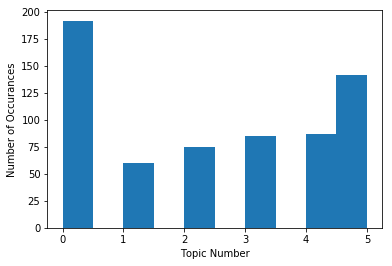

In [218]:
#Plotting the Topic vs. Frequency of Occurance in the 4th Quartile
#This is where the engagement score is the maximum. 

plt.ylabel("Number of Occurances")
plt.xlabel("Topic Number")
plt.hist(fourthquartile['Topic Final'])
plt.show()

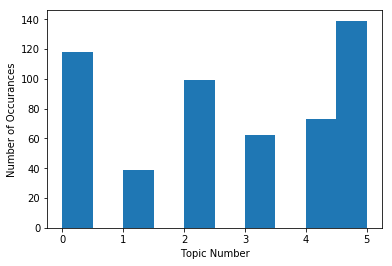

In [219]:
#Plotting the Topic vs. Frequency of Occurance in the 1st Quartile
#This is where the engagement score is the minimum. 

plt.ylabel("Number of Occurances")
plt.xlabel("Topic Number")
plt.hist(firstquartile['Topic Final'])
plt.show()

# Titles

In [231]:
titledata = videolabels2.copy()

In [232]:
#For each label which was a String, replace it with an array of labels. 

i=0
for comment in titledata['title']:
    temparray = comment.split(" ")
    #print(temparray[1:])
    youtube.at[i,'cleantitles'] = temparray[1:]
    i+=1
dataforlda.head(10)

,youID,title,thumbnail,Url,#Views,#Likes,#Dislikes,labels,engagement,combined,cleanlabels,Topic Final,Topic 1,Topic 4,Topic 2,Topic 3,Topic 0,Topic 5,cleantitles
0,T144Ht7miiw,Storms hit during one of the busiest travel we...,https://i.ytimg.com/vi/T144Ht7miiw/default.jpg,https://www.youtube.com/watch?v=T144Ht7miiw,0.000149,432.0,62.0,", Text, Mode of transport, Atmospheric phenome...",0.0,", Text, Mode of transport, Atmospheric phenome...",0,4.0,0.016814,0.915640,0.016889,0.016813,0.016974,0.016871,0
1,68GaOZ_wPrc,Winter forecast ahead of holiday travel rush l...,https://i.ytimg.com/vi/68GaOZ_wPrc/default.jpg,https://www.youtube.com/watch?v=68GaOZ_wPrc,0.001159,636.0,223.0,", News, Display device, Display advertising, T...",0.0,", News, Display device, Display advertising, T...",0,2.0,0.015194,0.015189,0.923833,0.015170,0.015266,0.015348,0
2,M49Klw46_w8,How will the East Coast storms affect holiday ...,https://i.ytimg.com/vi/M49Klw46_w8/default.jpg,https://www.youtube.com/watch?v=M49Klw46_w8,0.000377,165.0,45.0,", Text, Mode of transport, Font, Sky, Organism...",0.0,", Text, Mode of transport, Font, Sky, Organism...",0,0.0,0.016757,0.016790,0.417925,0.016765,0.514958,0.016806,0
3,vcbWKnPHflQ,Dangerous Weather Could Disrupt Thanksgiving T...,https://i.ytimg.com/vi/vcbWKnPHflQ/default.jpg,https://www.youtube.com/watch?v=vcbWKnPHflQ,0.000234,106.0,16.0,", Text, Atmospheric phenomenon, Mode of transp...",0.0,", Text, Atmospheric phenomenon, Mode of transp...",0,0.0,0.024002,0.024046,0.346032,0.024026,0.557849,0.024046,0
4,EWEWUEqDvjc,Travel Girl | Episode 26 | Trincomalee - (2019...,https://i.ytimg.com/vi/EWEWUEqDvjc/default.jpg,https://www.youtube.com/watch?v=EWEWUEqDvjc,0.000012,52.0,5.0,", Hindu temple, Temple, Place of worship, Tour...",0.0,", Hindu temple, Temple, Place of worship, Tour...",0,5.0,0.020865,0.021124,0.020883,0.020976,0.020899,0.895253,0
5,_EkO2ofPOXg,Jordan Vacation Travel Guide | Expedia (4K),https://i.ytimg.com/vi/_EkO2ofPOXg/default.jpg,https://www.youtube.com/watch?v=_EkO2ofPOXg,0.002396,2047.0,96.0,", Text, Font, Banner, Signage, Vehicle registr...",1.0,", Text, Font, Banner, Signage, Vehicle registr...",0,5.0,0.016702,0.016720,0.016720,0.016715,0.016789,0.916354,0
6,nPOO1Coe2DI,Dubai Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/nPOO1Coe2DI/default.jpg,https://www.youtube.com/watch?v=nPOO1Coe2DI,0.028123,17241.0,1077.0,", Text, Font, Advertising, Signage, Banner, Di...",1.0,", Text, Font, Advertising, Signage, Banner, Di...",0,5.0,0.015194,0.015295,0.015264,0.015206,0.015323,0.923718,0
7,LcKnx7I97yk,Dublin Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/LcKnx7I97yk/default.jpg,https://www.youtube.com/watch?v=LcKnx7I97yk,0.011211,7445.0,292.0,", Banner, Font, Text, Advertising, Mode of tra...",1.0,", Banner, Font, Text, Advertising, Mode of tra...",0,5.0,0.015223,0.015290,0.015215,0.015205,0.015301,0.923765,0
8,0Mv48ZM7gu4,Brisbane Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/0Mv48ZM7gu4/default.jpg,https://www.youtube.com/watch?v=0Mv48ZM7gu4,0.007065,3451.0,135.0,", Land lot, Grass, Font, Banner, Sport venue, ...",1.0,", Land lot, Grass, Font, Banner, Sport venue, ...",0,0.0,0.015365,0.015202,0.015191,0.015210,0.923759,0.015273,0
9,llq8Rjm6wKc,Stockholm Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/llq8Rjm6wKc/default.jpg,https://www.youtube.com/watch?v=llq8Rjm6wKc,0.001291,1807.0,47.0,", Text, Font, Lighting, Vehicle registration p...",1.0,", Text, Font, Lighting, Vehicle registration p...",0,5.0,0.015216,0.015412,0.015217,0.015282,0.015295,0.923578,0


In [233]:
youtube.head()

,cleanlabels,cleantitles
0,NaN,"[hit, during, one, of, the, busiest, travel, w..."
1,NaN,"[forecast, ahead, of, holiday, travel, rush, l..."
2,NaN,"[will, the, East, Coast, storms, affect, holid..."
3,NaN,"[Weather, Could, Disrupt, Thanksgiving, Travel..."
4,NaN,"[Girl, |, Episode, 26, |, Trincomalee, -, (201..."


In [238]:
master_list = []
i=0

for comment in titledata['title']:
        temparray = comment.split(" ")
        words = [word.lower() for word in temparray]

        #Remove single-character tokens (mostly punctuation)
        words = [word for word in words if len(word) > 1]
        master_list.extend(words)
    

wordfreq = FreqDist(master_list)
wordfreq   

FreqDist({'travel': 908, 'in': 579, 'vacation': 479, 'to': 442, 'trip': 422, 'destinations': 371, 'the': 370, 'top': 359, '10': 353, 'tourist': 338, ...})

In [239]:
#Converting the Cleaned 'labels' column into a dictionary.
dictionary = gensim.corpora.Dictionary(youtube['cleantitles'])

#Printing the dictionary
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 busiest
1 during
2 hit
3 of
4 one
5 the
6 travel
7 weeks
8 year
9 ABC
10 News


In [248]:
#Bag of words model uses the above dictionary to assign the key to the labels

bow_corpus = [dictionary.doc2bow(doc) for doc in youtube['cleantitles']]
bow_corpus

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1)],
 [(3, 1),
  (6, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1)],
 [(5, 1), (13, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)],
 [(10, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1)],
 [(29, 3), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)],
 [(27, 1), (29, 1), (37, 1), (38, 1), (39, 1), (40, 1)],
 [(27, 1), (29, 1), (38, 1), (39, 1), (40, 1)],
 [(27, 1), (29, 1), (38, 1), (39, 1), (40, 1)],
 [(27, 1), (29, 1), (38, 1), (39, 1), (40, 1)],
 [(27, 1), (29, 1), (38, 1), (39, 1), (40, 1)],
 [(5, 1), (6, 1), (13, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)],
 [(6, 1), (13, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1)],
 [(27, 1), (29, 1), (38, 1), (39, 1), (40, 1), (52, 1), (53, 1)],
 [(31, 1), (54, 1), (55, 1), (56, 1)],
 [(27, 1), (29, 1), (38, 1), (39, 1), (40, 1), (57, 1)],
 [(27, 1), (29, 1), (

In [249]:
#Creating a LDA model with topic = 5.
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [250]:
#These are the topic and the labels and weights associated with each of them

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"
Topic: 1 
Words: 0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"
Topic: 2 
Words: 0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"
Topic: 3 
Words: 0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"
Topic: 4 
Words: 0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"


In [251]:
#For each image we are assigning a Topic with the maximum weight amongst all the topics.
#Also we are savig the weights for each of the topics in separate columns.

i=0
for row in bow_corpus:
    ind =0
    sco =0 
    for index, score in sorted(lda_model[row], key=lambda tup: -1*tup[1]):
        if(ind ==0 and sco == 0):
            titledata.at[i,'Topic Final'] = index
            print("\nScore: {}\t \nTopic: {}\n{}".format(score,index,lda_model.print_topic(index, 10)))
        if(index == 0):
            titledata.at[i,'Topic 0']= score
        elif(index == 1):
            titledata.at[i,'Topic 1']= score
        elif(index == 2):
            titledata.at[i,'Topic 2']= score
        elif(index == 3):
            titledata.at[i,'Topic 3']= score
        else:
            titledata.at[i,'Topic 4']= score 
        ind+=1
        sco+=1 
    i+=1


Score: 0.9328402280807495	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.7400944232940674	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.9098697304725647	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.9183272123336792	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.9262371063232422	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.8850618600845337	 
Topic: 2
0.059*"Travel


Score: 0.8983821272850037	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.7977311015129089	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.918996274471283	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.6848907470703125	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.9326576590538025	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.9189330339431763	 
Topic: 0
0.047


Score: 0.9268525838851929	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.7986133098602295	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.9185040593147278	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.8989977240562439	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.884564220905304	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.9260632395744324	 
Topic: 0
0.


Score: 0.910403847694397	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.7321394085884094	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.918550968170166	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.9322282075881958	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.8389944434165955	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.8371533751487732	 
Top


Score: 0.8638335466384888	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.8988324403762817	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.8660324811935425	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.8658455014228821	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.7956542372703552	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.801662266254425	 
Topic: 4
0.036*"|"


Score: 0.9193624258041382	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.8643529415130615	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.8995688557624817	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.8838637471199036	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.9103134870529175	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.8644613027572632	 
Topic: 4
0.036*"|" + 


Score: 0.936113715171814	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.9190763235092163	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.8651103973388672	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.20000000298023224	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.9101803302764893	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.7960513234138489	 
Topic: 3
0.050*"-" + 0.027*"


Score: 0.9421314001083374	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.7308661341667175	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.8817523717880249	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.838193953037262	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.9418546557426453	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.8386538624763489	 
Topic: 3
0.050*"-" + 0.027*"T


Score: 0.8658034205436707	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.9463582038879395	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.9264448285102844	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.9461818933486938	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.9194758534431458	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.9096549153327942	 
Topic: 1
0.


Score: 0.635850191116333	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.9100357890129089	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.9323752522468567	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.93167644739151	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.9324089884757996	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.7973119616508484	 
Topic: 4
0.036*"|" + 0.


Score: 0.932283878326416	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.9190787076950073	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.88433837890625	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.9319584369659424	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.5926064252853394	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.4988430142402649	 
Topic: 1
0.028*"


Score: 0.8990820646286011	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.8327654004096985	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.9100821614265442	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.8986862301826477	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.839755654335022	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.6218258738517761	 
Topic: 1
0.028*"in" + 0.0


Score: 0.8383585214614868	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.6980276107788086	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.9322192072868347	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.9260455369949341	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.8654873371124268	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.8843898773193359	 
Topic: 3
0.050*"-" +


Score: 0.9375666975975037	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.8384031653404236	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.8990426063537598	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.8981921672821045	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.8987364172935486	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.8841779828071594	 
Topic: 4
0.036*


Score: 0.8384070992469788	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.9102196097373962	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.6142163872718811	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.838500440120697	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.8846921324729919	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.9490574598312378	 
Topic: 3
0.050*"-" + 0.02


Score: 0.8374713659286499	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.8988879919052124	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.5910285115242004	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.8849049806594849	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.5140672326087952	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.9102286100387573	 
Topic: 4
0.036*"|" + 0.0


Score: 0.86426842212677	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.8980615139007568	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.863844633102417	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.8981785178184509	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.8389983773231506	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.8389951586723328	 
Topic: 1
0.


Score: 0.7976664304733276	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.8652558326721191	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.9196470975875854	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.8982124328613281	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.8647245764732361	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.8844659924507141	 
Topic: 3
0.050


Score: 0.9313907027244568	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.9322583079338074	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.8838242888450623	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.8637915849685669	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.8984383940696716	 
Topic: 4
0.036*"|" + 0.023*"Tourist" + 0.019*"in" + 0.013*"Vacation" + 0.011*"Attractions" + 0.011*"Tourism" + 0.010*"10" + 0.010*"A" + 0.009*"In" + 0.008*"Best"

Score: 0.926388680934906	 
Topic: 1
0.028*"


Score: 0.8640328049659729	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.8337889313697815	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.9185864925384521	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.9327237606048584	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.8640437126159668	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.897268533706665	 
Topic: 3
0.05


Score: 0.7046850919723511	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.9322926998138428	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.952032208442688	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.8990275859832764	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.9315746426582336	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.9460079669952393	 
Topic: 1
0.028*"in


Score: 0.8972097635269165	 
Topic: 0
0.047*"-" + 0.023*"|" + 0.013*"the" + 0.013*"in" + 0.011*"Trip" + 0.009*"to" + 0.009*"Travel" + 0.007*"and" + 0.005*"Tourist" + 0.005*"destinations"

Score: 0.9328590631484985	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.9549990296363831	 
Topic: 2
0.059*"Travel" + 0.052*"|" + 0.029*"Guide" + 0.028*"Vacation" + 0.024*"-" + 0.019*"Trip" + 0.016*"Expedia" + 0.013*"to" + 0.013*"in" + 0.013*"Destinations"

Score: 0.8968748450279236	 
Topic: 3
0.050*"-" + 0.027*"Travel" + 0.018*"Vacation" + 0.018*"in" + 0.016*"|" + 0.016*"to" + 0.013*"Tourism" + 0.013*"Trip" + 0.009*"Destinations" + 0.009*"10"

Score: 0.8939166069030762	 
Topic: 1
0.028*"in" + 0.028*"Destinations" + 0.026*"|" + 0.024*"Travel" + 0.018*"to" + 0.015*"Tourist" + 0.013*"Best" + 0.013*"10" + 0.012*"the" + 0.010*"Popular"

Score: 0.9330645799636841	 
Topic: 1
0.028*

In [252]:
lowthreshold = titledata.describe().loc['25%','#Views']
highthreshold = titledata.describe().loc['75%','#Views']

In [253]:
firstquartile = titledata[titledata['#Views']<=lowthreshold].copy()
firstquartile

,youID,title,thumbnail,Url,#Views,#Likes,#Dislikes,labels,engagement,combined,Topic Final,Topic 1,Topic 0,Topic 3,Topic 2,Topic 4
4,EWEWUEqDvjc,Travel Girl | Episode 26 | Trincomalee - (2019...,https://i.ytimg.com/vi/EWEWUEqDvjc/default.jpg,https://www.youtube.com/watch?v=EWEWUEqDvjc,1.220720e-05,52.0,5.0,", Hindu temple, Temple, Place of worship, Tour...",0.0,", Hindu temple, Temple, Place of worship, Tour...",0.0,0.018365,0.926237,0.018366,0.018582,0.018450
10,Z43fVnDAZYQ,Busy holiday travel season on the roads and skies,https://i.ytimg.com/vi/Z43fVnDAZYQ/default.jpg,https://www.youtube.com/watch?v=Z43fVnDAZYQ,3.728523e-06,0.0,1.0,", Motor vehicle, Mode of transport, Vehicle, V...",0.0,", Motor vehicle, Mode of transport, Vehicle, V...",2.0,0.022833,0.023158,0.022794,0.908455,0.022760
23,kPWT6rz2z2M,PAKISTAN- 10 THINGS TO KNOW BEFORE TRAVELLING ...,https://i.ytimg.com/vi/kPWT6rz2z2M/default.jpg,https://www.youtube.com/watch?v=kPWT6rz2z2M,5.723764e-05,930.0,16.0,", Text, Font, Vehicle registration plate, Mode...",0.0,", Text, Font, Vehicle registration plate, Mode...",2.0,0.033532,0.033476,0.033622,0.865802,0.033568
29,ejG2hq_LM9U,"Sambil Menangis, Juru Bicara Korban Penipuan F...",https://i.ytimg.com/vi/ejG2hq_LM9U/default.jpg,https://www.youtube.com/watch?v=ejG2hq_LM9U,2.794210e-06,31.0,2.0,", People, Child, Smile, Photography, Vehicle",0.0,", People, Child, Smile, Photography, VehicleSa...",3.0,0.022852,0.022381,0.909752,0.022687,0.022328
32,wuBP8LbLNSQ,Holiday travel rush begins in Houston,https://i.ytimg.com/vi/wuBP8LbLNSQ/default.jpg,https://www.youtube.com/watch?v=wuBP8LbLNSQ,2.139317e-06,8.0,1.0,", Crowd, Event, Fun, Performance",0.0,", Crowd, Event, Fun, PerformanceHoliday travel...",2.0,0.033531,0.033476,0.033621,0.865804,0.033567
54,z3c6c25eaPo,The Science and Fiction of Time Travel - Part 2,https://i.ytimg.com/vi/z3c6c25eaPo/default.jpg,https://www.youtube.com/watch?v=z3c6c25eaPo,2.060730e-05,110.0,8.0,", Text, Font",0.0,", Text, FontThe Science and Fiction of Time Tr...",2.0,0.033532,0.033476,0.033619,0.865806,0.033568
81,n8qvFP07L8o,3-Day Travel Guide For Things To Do and Foods ...,https://i.ytimg.com/vi/n8qvFP07L8o/default.jpg,https://www.youtube.com/watch?v=n8qvFP07L8o,3.311138e-05,185.0,4.0,", Food, Cuisine, Dish, Ingredient, Ramen, Nood...",0.0,", Food, Cuisine, Dish, Ingredient, Ramen, Nood...",2.0,0.010625,0.010663,0.010707,0.957372,0.010632
83,87PeYmTXtOY,HUSBAND COOKING VLOG MALAYALAM | FT. HANNA DAN...,https://i.ytimg.com/vi/87PeYmTXtOY/default.jpg,https://www.youtube.com/watch?v=87PeYmTXtOY,4.549323e-05,236.0,4.0,", Font",0.0,", FontHUSBAND COOKING VLOG MALAYALAM | FT. HAN...",0.0,0.020076,0.919666,0.020078,0.020087,0.020093
89,_XM9L2VeMYI,Family Travel to the Nation&#39;s Capital,https://i.ytimg.com/vi/_XM9L2VeMYI/default.jpg,https://www.youtube.com/watch?v=_XM9L2VeMYI,5.396317e-06,52.0,2.0,", Transport, Product, Mode of transport, Techn...",0.0,", Transport, Product, Mode of transport, Techn...",3.0,0.020569,0.020635,0.917823,0.020556,0.020417
120,jE3Ne_YaiGY,Caravan to Quartzsite - A Travel Day with Friends,https://i.ytimg.com/vi/jE3Ne_YaiGY/default.jpg,https://www.youtube.com/watch?v=jE3Ne_YaiGY,4.425330e-05,776.0,11.0,", Mode of transport, Font, Photo caption",0.0,", Mode of transport, Font, Photo captionCarava...",3.0,0.018512,0.018359,0.926239,0.018588,0.018301


In [254]:
fourthquartile = titledata[titledata['#Views']>= highthreshold].copy()
fourthquartile

,youID,title,thumbnail,Url,#Views,#Likes,#Dislikes,labels,engagement,combined,Topic Final,Topic 1,Topic 0,Topic 3,Topic 2,Topic 4
6,nPOO1Coe2DI,Dubai Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/nPOO1Coe2DI/default.jpg,https://www.youtube.com/watch?v=nPOO1Coe2DI,0.028123,17241.0,1077.0,", Text, Font, Advertising, Signage, Banner, Di...",1.0,", Text, Font, Advertising, Signage, Banner, Di...",2.0,0.033531,0.033476,0.033613,0.865815,0.033565
7,LcKnx7I97yk,Dublin Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/LcKnx7I97yk/default.jpg,https://www.youtube.com/watch?v=LcKnx7I97yk,0.011211,7445.0,292.0,", Banner, Font, Text, Advertising, Mode of tra...",1.0,", Banner, Font, Text, Advertising, Mode of tra...",2.0,0.033532,0.033476,0.033621,0.865805,0.033566
12,ieWNzZPfZzk,Rio de Janeiro Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/ieWNzZPfZzk/default.jpg,https://www.youtube.com/watch?v=ieWNzZPfZzk,0.015946,8305.0,482.0,", Text, Font, Advertising, Display device, Mod...",1.0,", Text, Font, Advertising, Display device, Mod...",2.0,0.025111,0.025083,0.025338,0.899339,0.025129
16,srP7RFVdjWc,Cape Town Vacation Travel Guide | Expedia (4K),https://i.ytimg.com/vi/srP7RFVdjWc/default.jpg,https://www.youtube.com/watch?v=srP7RFVdjWc,0.012367,7886.0,272.0,", Nature, Text, Banner, Font, Sky, Water, Adve...",1.0,", Nature, Text, Banner, Font, Sky, Water, Adve...",2.0,0.033532,0.033476,0.033622,0.865803,0.033567
18,Oo6iAxf4si0,San Francisco Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/Oo6iAxf4si0/default.jpg,https://www.youtube.com/watch?v=Oo6iAxf4si0,0.034436,16882.0,758.0,", Text, Landmark, Font, Sky, Mode of transport...",1.0,", Text, Landmark, Font, Sky, Mode of transport...",2.0,0.033532,0.033476,0.033619,0.865806,0.033567
19,nD_dFyfOXIo,Patagonia Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/nD_dFyfOXIo/default.jpg,https://www.youtube.com/watch?v=nD_dFyfOXIo,0.015364,8500.0,311.0,", Nature, Sky, Text, Font, Shore, Mode of tran...",1.0,", Nature, Sky, Text, Font, Shore, Mode of tran...",2.0,0.025325,0.025113,0.025147,0.899293,0.025123
21,45ETZ1xvHS0,London Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/45ETZ1xvHS0/default.jpg,https://www.youtube.com/watch?v=45ETZ1xvHS0,0.030444,15207.0,786.0,", Vehicle registration plate, Text, Signage, F...",1.0,", Vehicle registration plate, Text, Signage, F...",1.0,0.926127,0.018683,0.018311,0.018543,0.018337
30,sRyslbdtT90,31 INSANELY AFFORDABLE Budget Travel Destinati...,https://i.ytimg.com/vi/sRyslbdtT90/default.jpg,https://www.youtube.com/watch?v=sRyslbdtT90,0.068659,262482.0,6009.0,", Technology, Font, Games, Electronic device, ...",1.0,", Technology, Font, Games, Electronic device, ...",2.0,0.033532,0.033476,0.033620,0.865805,0.033567
31,7uY0Ab5HlZ0,Toronto Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/7uY0Ab5HlZ0/default.jpg,https://www.youtube.com/watch?v=7uY0Ab5HlZ0,0.015328,8087.0,304.0,", Text, Font, Banner, Display advertising, Adv...",1.0,", Text, Font, Banner, Display advertising, Adv...",0.0,0.034174,0.864215,0.033881,0.033704,0.034026
35,RLOsQViPLhw,Melbourne Vacation Travel Guide | Expedia,https://i.ytimg.com/vi/RLOsQViPLhw/default.jpg,https://www.youtube.com/watch?v=RLOsQViPLhw,0.010953,4838.0,198.0,", Font, Landmark, Text, Advertising, Display a...",1.0,", Font, Landmark, Text, Advertising, Display a...",2.0,0.033532,0.033476,0.033626,0.865800,0.033567


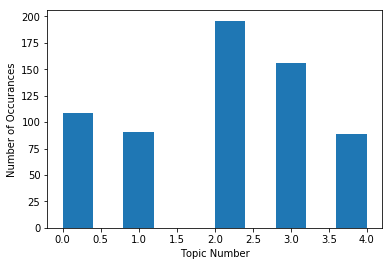

In [255]:
#Plotting the Topic vs. Frequency of Occurance in the 4th Quartile
#This is where the engagement score is the maximum. 

plt.ylabel("Number of Occurances")
plt.xlabel("Topic Number")
plt.hist(fourthquartile['Topic Final'])
plt.show()

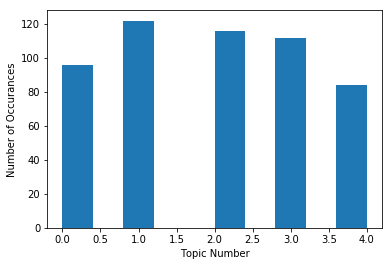

In [256]:
#Plotting the Topic vs. Frequency of Occurance in the 1st Quartile
#This is where the engagement score is the minimum. 

plt.ylabel("Number of Occurances")
plt.xlabel("Topic Number")
plt.hist(firstquartile['Topic Final'])
plt.show()